# Monte Carlo simulation of Dickey–Fuller distributions
1. How does unit root processes look?
2. Simulation of ADF $\tau$ critical values
3. Simulation of ADF $\Phi$ critical values
4. Simulation of ADF critical values for use on residuals from Engel-Granger methodology
5. Matrix simulation of $\tau$

In [45]:
suppressMessages(library(tidyverse)) # Readr, ggplot, dplyr, ...
suppressMessages(library(gridExtra)) # Arrangning ggplots
suppressMessages(library(readxl))    # Loading excel
suppressMessages(library(repr))      # Resizing the plots in jupyter
suppressMessages(library(rugarch))   # For ARCH and GARCH models
suppressMessages(library(dynlm))     # Lagged linear models
suppressMessages(library(urca))      # Dick Fuller test
suppressMessages(library(car))       # Linear hyphothesis testing
suppressMessages(library(tseries))   # Adf-test
suppressMessages(library(vars))      # VAR models
suppressMessages(library(zoo))       # Convert quarters to date
suppressMessages(library(forecast))  # Help in plotting TS
suppressMessages(library(fGarch))    # The library Lasse uses to do GARCH
suppressMessages(library(expm))      # Matrix calculations 

# Simulations
First number of simulations should be set sufficiently high, this should be several thousand since we're not estimating the mean but the upper and lower quantiles. This is computationally heavy and therefore start with 1000, which should be <5 min. 

Sample size should be set according to the dataset

**Dickey Fuller test**

$$
\begin{aligned}
\Delta y_t = a_0 + \gamma y_{t-1} + a_2t + \varepsilon_t \qquad \qquad
\gamma &= 0 \qquad \tau_1 \\
a_2 = \gamma &= 0 \qquad \phi_3 \\
a_0 = a_2 = \gamma &= 0 \qquad \phi_2 \\
\\
\Delta y_t = a_0 + \gamma y_{t-1} + \varepsilon_t \qquad \qquad
\gamma &= 0 \qquad \tau_2 \\
a_0 = \gamma  &= 0 \qquad \phi_1 \\
\\
\Delta y_t = \gamma y_{t-1} + \varepsilon_t \qquad \qquad
\gamma &= 0 \qquad \tau_3 \\
\end{aligned}
$$

**Augmented Dickey Fuller test**

$$
\Delta y_t = a_0 + \gamma y_{t-1} + a_2t + \sum^p_{i=2}\beta_i\Delta y_{t-i+1} + \varepsilon_t
$$

Remember the $H_0$ is always that the process contains a unit root, therefore if we can reject it we conclude that the series is stationary and ready for further analisis. 

In [74]:
nsim <- 5000
nsample <- 100

subt <- paste(nsim, "simulations  -", nsample,"samples in each") # for use in plotting

# Different data generating processes
For difference stationary series (series containing a unit root) shocks are permanent and they might wander far from the trend, this is not true for stationary and trend stationary series, it can be hard to see the difference in the plots below, but if you are not convinced extend the sample size from 100 to 1000 and it will be clear that the stationary series has a constant variance opposed to the series containing an unit root.

All four series might also include a drift term (intercept other than 0), this will not change wether the processes contain a unit root or not, but is important when it comes to deciding which deterministic components to include in the Dickey Fuller test.

For all four series 95 % confidence interval are plottet, $1.96 * SD$, for the unit root standard deviation is equal to $\sqrt{t}$ for the AR(2) process used to plot the stationary series $y_t = 0.6y_{t-1} + 0.3y_{t-2} + \varepsilon_t$ the variance is calculated as $Var(y_t) = \sigma^2 (1+\beta^2_1 + \beta^2_2)$

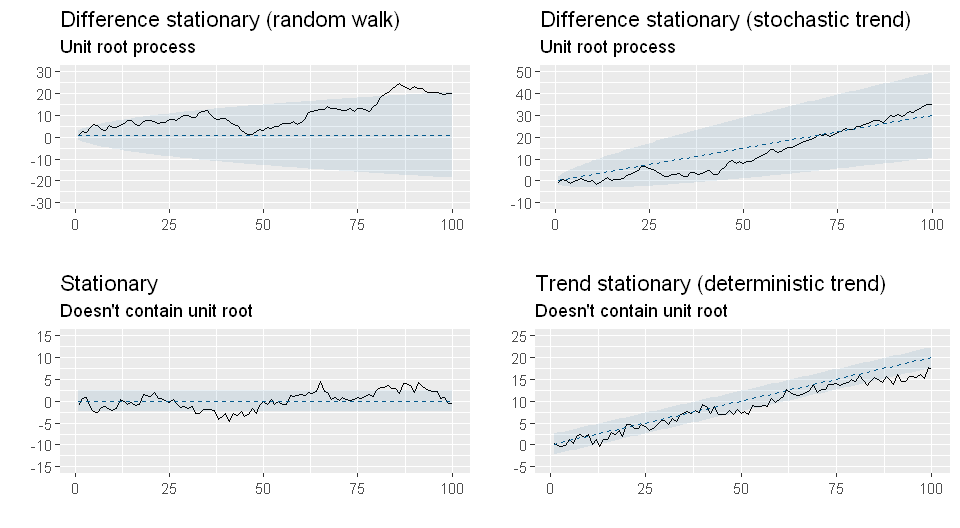

In [83]:
options(repr.plot.width = 8, repr.plot.height = 4.4)

a1 <- ggplot(data.frame(x = 1:100, b = cumsum(rnorm(100)), sd = sqrt(1:100), t = 1), aes(x, b)) + 
  geom_line() + geom_line(aes(x, t), color = "#045a8d", linetype = "dashed") + 
  geom_ribbon(aes(ymin = t - sd * 1.96, ymax = t + sd * 1.96), alpha = 0.09, fill = "#045a8d") + 
  scale_y_continuous(limits = c(-30, 30), breaks = seq(-30, 30, 10)) +
  labs(title = "Difference stationary (random walk)", x = "", y = "", subtitle = "Unit root process")

a2 <- ggplot(data.frame(x = 1:100, b = cumsum(rnorm(100) + 0.3), sd = sqrt(1:100), t = 0.3 * 1:100), aes(x, b)) + 
  geom_line() + geom_line(aes(x, t), color = "#045a8d", linetype = "dashed") + 
  geom_ribbon(aes(ymin = t - sd * 1.96, ymax = t + sd * 1.96), alpha = 0.09, fill = "#045a8d") + 
  scale_y_continuous(limits = c(-10, 50), breaks = seq(-10, 50, 10)) +
  labs(title = "Difference stationary (stochastic trend)", x = "", y = "", subtitle = "Unit root process")

sim <- arima.sim(n = 100, list(ar = c(0.6, 0.3)))
a3 <- ggplot(data.frame(x = 1:100, sim, sd = sqrt(1 * (1 + 0.6^2 + 0.3^2)), d = 0), aes(x, sim)) + 
  geom_line() + geom_line(aes(x, d), color = "#045a8d", linetype = "dashed") + 
  geom_ribbon(aes(ymin = d - sd * 1.96, ymax = d + sd * 1.96), alpha = 0.09, fill = "#045a8d") + 
  scale_y_continuous(limits = c(-15, 15), breaks = seq(-15, 15, 5)) +
  labs(title = "Stationary", x = "", y = "", subtitle = "Doesn't contain unit root")

sim2 <- arima.sim(n = 100, list(ar = c(0.6, 0.3))) 
a4 <- ggplot(data.frame(x = 1:100, sim2 = sim2 + 1:100 * 0.2, sd = sqrt(1 * (1 + 0.6^2 + 0.3^2)), d = 0 + 1:100 * 0.2), aes(x, sim2)) + 
  geom_line() + geom_line(aes(x, d), color = "#045a8d", linetype = "dashed") + 
  geom_ribbon(aes(ymin = d - sd * 1.96, ymax = d + sd * 1.96), alpha = 0.09, fill = "#045a8d") + 
  scale_y_continuous(limits = c(-5, 25), breaks = seq(-5, 25, 5)) +
  labs(title = "Trend stationary (deterministic trend)", x = "", y = "", subtitle = "Doesn't contain unit root")

grid.arrange(a1, a2, a3, a4, ncol = 2)

# Simulations of $\tau$ and $\phi$

#### $\tau_1$ - simulation with gamma, drift and trend

In [48]:
tau1 <- NA
for (i in 1:nsim) {
    x <- as.ts(cumsum(rnorm(nsample)))
    a <- summary(dynlm(x ~ L(x) + seq_along(x)))
    new <- (a$coefficients["L(x)", "Estimate"] - 1)/a$coefficients["L(x)", "Std. Error"]
    tau1[i] <- new
}

#### $\tau_2$ - simulation with gamma and drift

In [49]:
tau2 <- NA
for (i in 1:nsim) {
    x <- as.ts(cumsum(rnorm(nsample)))
    a <- summary(dynlm(x ~ L(x)))
    new <- (a$coefficients["L(x)", "Estimate"] - 1)/a$coefficients["L(x)", "Std. Error"]
    tau2[i] <- new
}

#### $\tau_3$ - simulation with gamma

In [64]:
tau3 <- NA
for (i in 1:nsim) {
    x <- as.ts(cumsum(rnorm(nsample)))
    a <- summary(dynlm(x ~ L(x) + 0))
    new <- (a$coefficients["L(x)", "Estimate"] - 1)/a$coefficients["L(x)", "Std. Error"]
    tau3[i] <- new
}

#### $\phi_1$ - F-test of gamma and drift = 0 for $\tau_2$ 

In [51]:
phi1 <- NA
for (i in 1:nsim) {
    x <- as.ts(cumsum(rnorm(nsample)))
    reg <- dynlm(x ~ L(x))
    new <- linearHypothesis(reg, c("L(x) = 1", "(Intercept) = 0"), test="F")$F[2]
    phi1[i] <- new
}

#### $\phi_2$ - F-test of gamma, drift and trend = 0 for $\tau_1$ 

In [52]:
phi2 <- NA
for (i in 1:nsim) {
    x <- as.ts(cumsum(rnorm(nsample)))
    reg <- dynlm(x ~ L(x) + seq_along(x))
    new <- linearHypothesis(reg, c("L(x) = 1", "seq_along(x) = 0", "(Intercept) = 0"), test="F")$F[2]
    phi2[i] <- new
}

#### $\phi_3$ - F-test of gamma and drift = 0 for $\tau_1$ 

In [53]:
phi3 <- NA
for (i in 1:nsim) {
    x <- as.ts(cumsum(rnorm(nsample)))
    reg <- dynlm(x ~ L(x) + seq_along(x))
    new <- linearHypothesis(reg, c("L(x) = 1", "seq_along(x) = 0"), test="F")$F[2]
    phi3[i] <- new
}

# Critical values for Dickey Fuller

In [54]:
zndist <- rnorm(nsim)

ndistq <- quantile(zndist, probs = c(0.01,0.025,0.05))
tau1q <- quantile(tau1, probs = c(0.01,0.025,0.05))
tau2q <- quantile(tau2, probs = c(0.01,0.025,0.05))
tau3q <- quantile(tau3, probs = c(0.01,0.025,0.05))
phi1q <- quantile(phi1, probs = c(0.99,0.975,0.95))
phi2q <- quantile(phi2, probs = c(0.99,0.975,0.95))
phi3q <- quantile(phi3, probs = c(0.99,0.975,0.95))

quantiles <- cbind(tau1q, tau2q, tau3q, ndistq, phi1q, phi2q, phi3q)
colnames(quantiles) = c("Tau 1", "Tau 2", "Tau 3", "Normal Dist", "Phi 1", "Phi 2", "Phi 3")
quantiles

,Tau 1,Tau 2,Tau 3,Normal Dist,Phi 1,Phi 2,Phi 3
1%,-3.991857,-3.465318,-2.498450,-2.262840,6.411096,6.437624,9.016553
2.5%,-3.693366,-3.165428,-2.160332,-1.946046,5.535904,5.550943,7.659401
5%,-3.441481,-2.913482,-1.926183,-1.651786,4.838663,4.872478,6.495627


# Visualisation of distributions

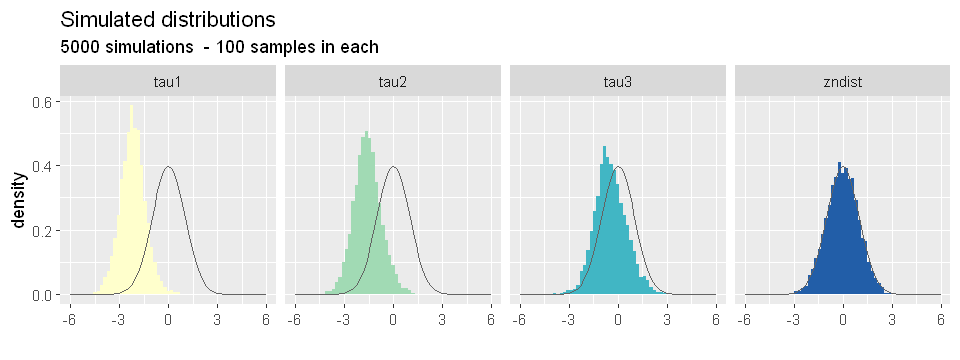

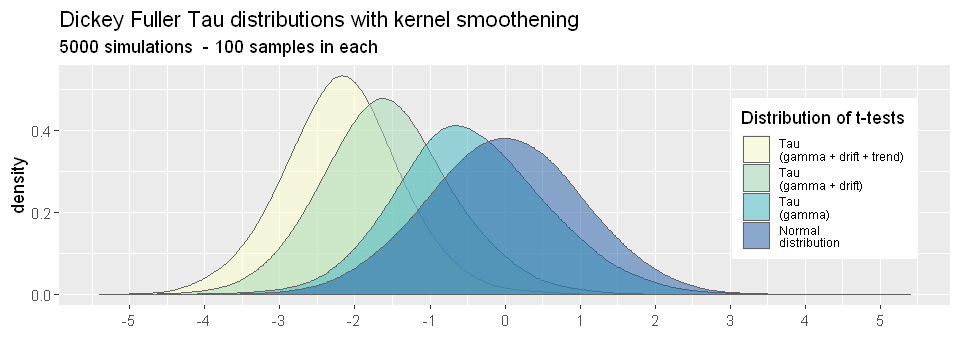

In [70]:
options(repr.plot.width=8, repr.plot.height=3)

adf <- data.frame(zndist,tau1,tau2,tau3) %>% gather(variable, value)
p1 <- ggplot(adf, aes(value, fill=variable)) + 
  geom_histogram(bins=60, aes(y = ..density..)) + 
  scale_fill_brewer(guide=F, palette="YlGnBu") +
  stat_function(fun=dnorm, color="#636363", args=list(mean=0, sd=1)) +
  facet_wrap(~variable, nrow=1) + 
  scale_x_continuous(limits = c(-6, 6)) +
  labs(title="Simulated distributions", subtitle = subt, x="")

df <- data.frame(tau1, tau2, tau3, zndist) %>% gather(variable, value)
p2 <- ggplot(df, aes(value, fill=variable)) + 
  geom_density(adjust=2, alpha=0.5, color="#636363") + 
  scale_fill_brewer(name="Distribution of t-tests", 
                    labels = c("Tau\n(gamma + drift + trend)", 
                               "Tau\n(gamma + drift)", 
                               "Tau\n(gamma)",
                               "Normal\ndistribution"), 
                    palette="YlGnBu", direction=1) + 
  labs(title="Dickey Fuller Tau distributions with kernel smoothening", subtitle=subt, x="") + 
  scale_x_continuous(limits = c(-5.4, 5.4), breaks=seq(-5,5,by=1)) +
  theme(legend.text=element_text(size=7),
        legend.justification = c(1, 1), 
        legend.box.margin=margin(c(20,20,50,50)),
        legend.position = c(1, 1))

suppressWarnings(print(p1)); suppressWarnings(print(p2))

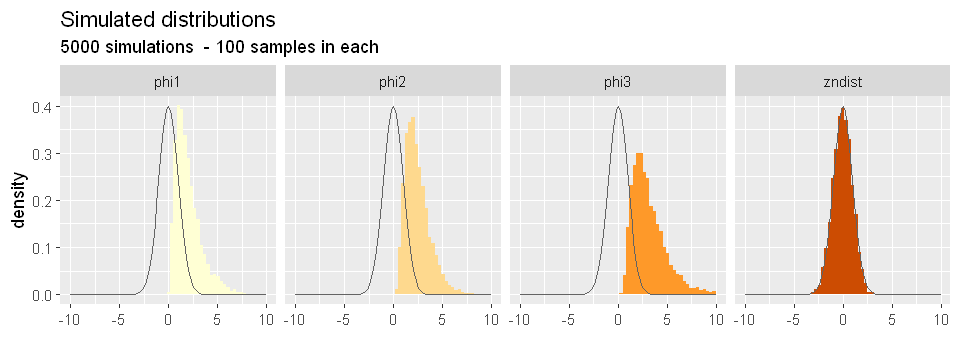

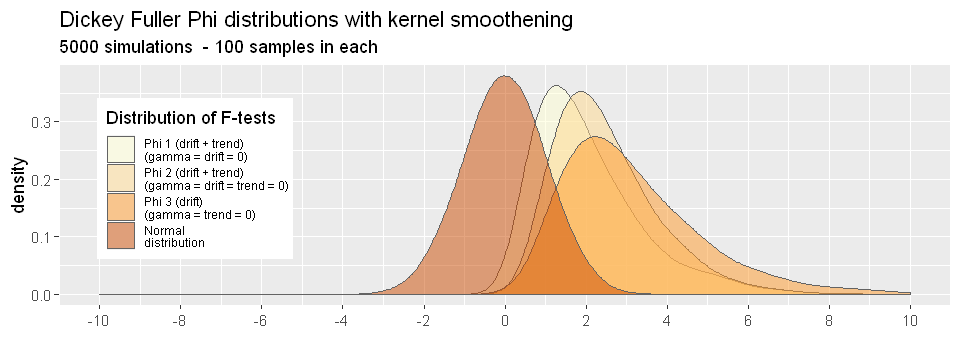

In [56]:
adf <- data.frame(phi1,phi2,phi3, zndist) %>% gather(variable, value)
p1 <- ggplot(adf, aes(value, fill=variable)) + 
  geom_histogram(bins=60, aes(y = ..density..)) + 
  scale_fill_brewer(guide=F, palette="YlOrBr") +
  stat_function(fun=dnorm, color="#636363", args=list(mean=0, sd=1)) +
  facet_wrap(~variable, nrow=1) + 
  scale_x_continuous(limits = c(-10, 10)) +
  labs(title="Simulated distributions", subtitle=subt, x="")

df <- data.frame(phi1, phi2, phi3, zndist) %>% gather(variable, value)
p2 <- ggplot(df, aes(value, fill=variable)) + 
  geom_density(adjust=2, alpha=0.5, color="#636363") + 
  scale_fill_brewer(name="Distribution of F-tests", 
                    labels = c("Phi 1 (drift + trend)\n(gamma = drift = 0)", 
                               "Phi 2 (drift + trend)\n(gamma = drift = trend = 0)", 
                               "Phi 3 (drift)\n(gamma = trend = 0)",
                               "Normal\ndistribution"), 
                    palette="YlOrBr", direction=1) + 
  labs(title="Dickey Fuller Phi distributions with kernel smoothening", subtitle=subt, x="") + 
  scale_x_continuous(limits = c(-10, 10), breaks=seq(-10,10,by=2)) +
  theme(legend.text=element_text(size=7),
        legend.justification = c(1, 1), 
        legend.box.margin=margin(c(20,20,50,50)),
        legend.position = c(0.3, 1))

suppressWarnings(print(p1)); suppressWarnings(print(p2))

# Simulation of critical values for Engel Granger methodology
In the engel granger precedure we need to find if the residual of a linear combination of variables is stationary, here we can't rely on the standard critical values we have calculated above. This is something about the residuals comming from a regression and several variables and this changes the critical values. There are alot more possible values to calculate but i've done it 2 - 5 variables and for series with intercept but not trend. These are the things of interest to find the right critical value:
- Samle size
- Number of variables
- Deterministic parametres (drift, trend)

In [57]:
EG2 <- NA
for (i in 1:nsim) {
    x1 <- as.ts(cumsum(rnorm(nsample)))
    x2 <- as.ts(cumsum(rnorm(nsample)))
    res <- as.ts(lm(x1 ~ x2)$residuals)
    a <- summary(dynlm(res ~ L(res)))
    EG2[i] <- (a$coefficients["L(res)", "Estimate"] - 1)/a$coefficients["L(res)", "Std. Error"]
}

In [66]:
EG3 <- NA
for (i in 1:nsim) {
    x1 <- as.ts(cumsum(rnorm(nsample)))
    x2 <- as.ts(cumsum(rnorm(nsample)))
    x3 <- as.ts(cumsum(rnorm(nsample)))
    res <- as.ts(lm(x1 ~ x2 + x3)$residuals)
    a <- summary(dynlm(res ~ L(res)))
    EG3[i] <- (a$coefficients["L(res)", "Estimate"] - 1)/a$coefficients["L(res)", "Std. Error"]
}

In [59]:
EG4 <- NA
for (i in 1:nsim) {
    x1 <- as.ts(cumsum(rnorm(nsample)))
    x2 <- as.ts(cumsum(rnorm(nsample)))
    x3 <- as.ts(cumsum(rnorm(nsample)))
    x4 <- as.ts(cumsum(rnorm(nsample)))
    res <- as.ts(lm(x1 ~ x2 + x3 + x4)$residuals)
    a <- summary(dynlm(res ~ L(res)))
    EG4[i] <- (a$coefficients["L(res)", "Estimate"] - 1)/a$coefficients["L(res)", "Std. Error"]
}

In [60]:
EG5 <- NA
for (i in 1:nsim) {
    x1 <- as.ts(cumsum(rnorm(nsample)))
    x2 <- as.ts(cumsum(rnorm(nsample)))
    x3 <- as.ts(cumsum(rnorm(nsample)))
    x4 <- as.ts(cumsum(rnorm(nsample)))
    x5 <- as.ts(cumsum(rnorm(nsample)))
    res <- as.ts(lm(x1 ~ x2 + x3 + x4 + x5)$residuals)
    a <- summary(dynlm(res ~ L(res)))
    EG5[i] <- (a$coefficients["L(res)", "Estimate"] - 1)/a$coefficients["L(res)", "Std. Error"]
}

In [68]:
qEG2 <- quantile(EG2, probs = c(0.01,0.05,0.10))
qEG3 <- quantile(EG3, probs = c(0.01,0.05,0.10))
qEG4 <- quantile(EG4, probs = c(0.01,0.05,0.10))
qEG5 <- quantile(EG5, probs = c(0.01,0.05,0.10))

quantiles <- cbind(qEG2, qEG3, qEG4, qEG5, ndistq)
colnames(quantiles) = c("Two Variables", "Three Variables", "Four Variables", "Five Variables", "Normal Dist")
quantiles

,Two Variables,Three Variables,Four Variables,Five Variables,Normal Dist
1%,-3.993993,-4.535778,-4.803193,-5.194159,-2.262840
5%,-3.411322,-3.854982,-4.212881,-4.567770,-1.946046
10%,-3.076628,-3.506834,-3.895925,-4.243386,-1.651786


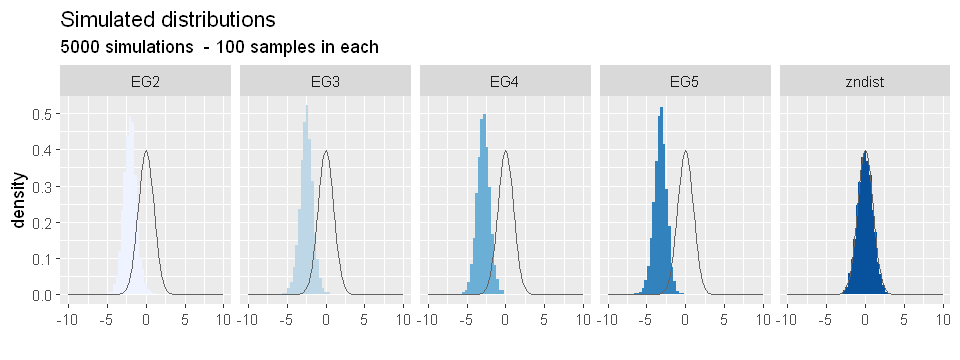

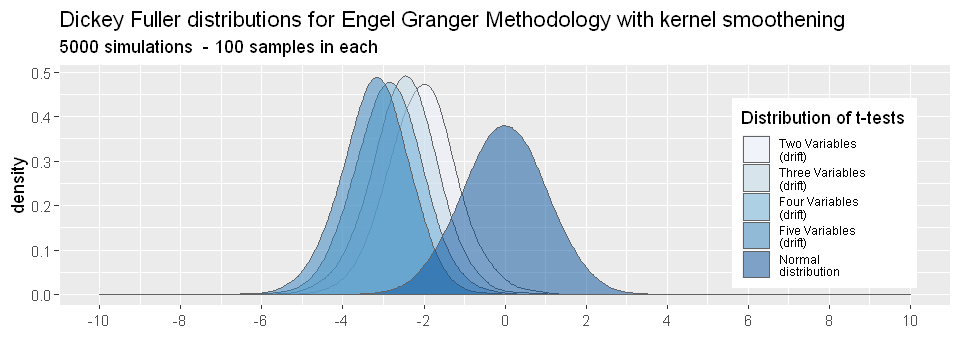

In [72]:
adf <- data.frame(EG2, EG3, EG4, EG5, zndist) %>% gather(variable, value)
p1 <- ggplot(adf, aes(value, fill=variable)) + 
  geom_histogram(bins=60, aes(y = ..density..)) + 
  scale_fill_brewer(guide=F, palette="Blues") +
  stat_function(fun=dnorm, color="#636363", args=list(mean=0, sd=1)) +
  facet_wrap(~variable, nrow=1) + 
  scale_x_continuous(limits = c(-10, 10)) +
  labs(title="Simulated distributions", subtitle=subt, x="")

df <- data.frame(EG2, EG3, EG4, EG5, zndist) %>% gather(variable, value)
p2 <- ggplot(df, aes(value, fill=variable)) + 
  geom_density(adjust=2, alpha=0.5, color="#636363") + 
  scale_fill_brewer(name="Distribution of t-tests", 
                    labels = c("Two Variables\n(drift)", 
                               "Three Variables\n(drift)", 
                               "Four Variables\n(drift)",
                               "Five Variables\n(drift)",
                               "Normal\ndistribution"), 
                    palette="Blues", direction=1) + 
  labs(title="Dickey Fuller distributions for Engel Granger Methodology with kernel smoothening", subtitle=subt, x="") + 
  scale_x_continuous(limits = c(-10, 10), breaks=seq(-10,10,by=2)) +
  theme(legend.text=element_text(size=7),
        legend.justification = c(1, 1), 
        legend.box.margin=margin(c(20,20,50,50)),
        legend.position = c(1, 1))

suppressWarnings(print(p1)); suppressWarnings(print(p2))

# Simulating with matrix formulas (significaltly faster, not my code)

In [63]:
T = 100
df <- rep(NA, 10000)

for (i in 1:10000) {
yt <- cumsum(rnorm(T))
X <- cbind(1,yt[-T])
beta <- solve(t(X) %*% X) %*% t(X) %*% yt[-1] 
ssr <- sum((yt[-1] - X %*% beta)^2)
se <- sqrt(ssr / (T-3)) / sqrt(sum((X[,2] - mean(X[,2]))^2))
df[i] <- (beta[2] - 1) / se
}

df %>%
  quantile(probs = c(0.01, 0.025, 0.05)) %>%
  as.data.frame()

,.
1%,-3.477146
2.5%,-3.157797
5%,-2.894760
